# The Mandelbrot Set
### High performance computing with Python
### by Søren Heidelbach, 2023-07-14

This project aims to implementation a module for estimating the Mandelbrot set and how to optimise the implementaion.

## Introduction

The Mandelbrot set is a set of complex numbers $c$ for which the function $f_c(z) = z^2 + c$ does not diverge when iterated from an initial $z=0$. Divergence is defined as the absolute value of $z$ becoming larger than a certain threshold $T$. The divergence rate is defined as the number of iterations before the absolute value of $z$ becomes larger than $T$, divided by the maximum allowed iterations before convergence is assumed. The Mandelbrot set is there also the set of complex numbers $c$ for which the divergence rate is equal to 1.

In [1]:
import mandelbrot.mandelbrot as mb
import mandelbrot.visualisation as viz
import mandelbrot.utils as utils
import mandelbrot.benchmark as benchmark
import mandelbrot.GPT4 as gpt4
import numpy as np
from numba import set_num_threads
import matplotlib.pyplot as plt
complex_array = utils.generate_complex_array(real_range=(-2, 1), img_range=(-1.5, 1.5), size=1000)

/home/shei/anaconda3/envs/sci_comp/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Naive implementation

The mandelbrot set can be estimated by iterating over a grid of complex numbers $c$ and for each $c$ iterate the function $f_c(z)$ until the absolute value of $z$ becomes larger than $T$ or the maximum number of iterations is reached. The number of iterations before divergence is then used to estimate the divergence rate. The following code implements this naive approach.

First a inner function that determines the divergence rate for a given complex number $c$ is defined:
  
```python
def mandelbrot(c, max_iterations=1000, divergence_limit=2):
    z =  0
    for i in range(max_iterations):
        z = z ** 2 + c
        if abs(z) > divergence_limit:
            return 1 - (i + 1)/max_iterations
    # If no divergence, retrn rate of 0
    return 0
```

Then an outer function that iterates over a grid of complex numbers $c$ and calls the inner function for each $c$ is defined:

```python
def mandelbrot_set(complex_array):
    convergence_rate = np.empty_like(complex_array)
    for real_index in range(complex_array.shape[0]):
        for imginary_index in range(complex_array.shape[1]):
            convergence_rate[real_index, imginary_index] = mandelbrot_naive(complex_array[real_index, imginary_index])
    return convergence_rate
```

We can visualise the result by plotting the convergence rate for each complex number $c$ a grid, where the color represents the divergence rate.

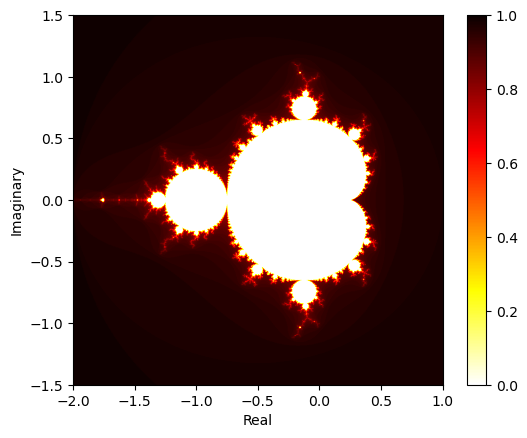

In [9]:
viz.plot_mandelbrot_set(mb.mandelbrot_set_naive(complex_array))

Running the function and plotting the resulting stability array shows the recogniseable mandelbrot set. 

## Different implementations

**Naive** - It has already been shown in the before block.

**Vectorised** - The vectorised implementation is based on the naive implementation, but instead of iterating over each complex number $c$ in a grid, the function is vectorised by multiplying  the array of complex numbers with itself elementwise.

**Numba** - The numba implementation is based on the naive implementation, but the inner function is decorated with the numba jit flag The outer function is also decorated with the jit flag. 

**Numba vectorised** - The numba vectorised implementation is based on the vectorised implementation, but the function is decorated with the numba jit flag. 

**Numba parallel** - The numba parallel implementation is based on the naive implementation, but the function is decorated with the numba jit flag and the parallel flag. 



## Becnhmarking

### Benchmarking setup
To check the execution time of all the methods, the execution time is calculated as seen in this python snippet:

```python
# First run to account for initiations
divergence = method_function(complex_array)

# Second run to measure execution time
start_time = time.time()
divergence = method_function(complex_array)

# Return execution time
execution_time = time.time() - start_time
```

An initial run is made to account for any initiations that might be made by the functions. Then a second run is made to measure the execution time. The execution time is then returned.

### Benchmarking results

First all implemented method for getting the divergence rate for each complex number $c$ in a grid is benchmarked. The results are shown in the table below.
The complex array is generated with different grid sizes, to see how the execution time scales with the grid size.


In [4]:
benchmarks = {}

set_num_threads(1)
for method in [
        mb.mandelbrot_set_naive, 
        mb.mandelbrot_set_vectorised, 
        mb.mandelbrot_set_vectorised_numba,
        mb.mandelbrot_set_numba, 
        mb.mandelbrot_set_numba_parallel
    ]:
    times = []
    resolution = []
    for res in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        bench = benchmark.time_method(method, resolution=res)
        times.append(list(bench.values())[0])
        resolution.append(res)
    benchmarks[method.__name__.replace("mandelbrot_set_", "")] = [times, resolution]



Text(0.5, 1.0, 'Execution time of mandelbrot set methods')

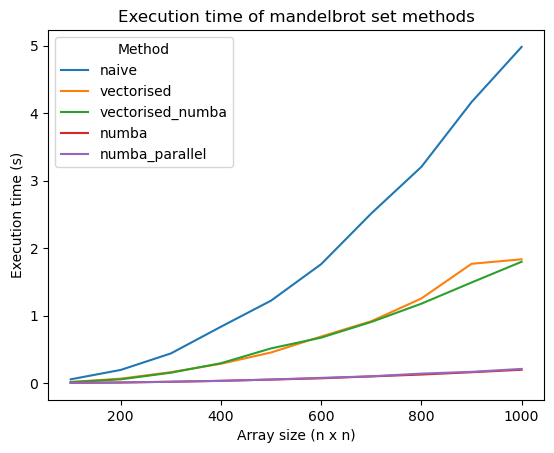

In [5]:
for method in benchmarks.keys():
    plt.plot(benchmarks[method][1], benchmarks[method][0], label=method)
plt.legend(loc='upper left', title="Method")
plt.xlabel('Array size (n x n)')
plt.ylabel('Execution time (s)')
plt.title('Execution time of mandelbrot set methods')

We can clearly see some speed up comapred to the naive implementation. The numba and numba parallel implementations are the fastest, followed by the vectorised and vectorised numba implementations. The naive implementation is the slowest. 

## Parallelisation

We can clearly see that the numba implementations are the best of the ones tested here. Now we can look at how the numba parallel implementation scales with the number of threads used.

Because the numba implementaiton is much faster, we can evaluate the execution time for a larger grid size. The computer i am currently using has 8 cores, so we can test how the execution time scales with the number of threads used.

```python
@njit("Array(float64, 2, 'A', False, aligned=True)(Array(complex128, 2, 'A', False, aligned=True))", nopython=True, parallel=True)
def mandelbrot_set_numba_parallel():
    <mandelbrot_set_numba code>
```
A multiprocessing implementation is made, where the complex array is split into chunks and each chunk is processed in a separate process. The results are then concatenated and returned. The multiprocessing implementation is shown below.

```python
def process_chunk(chunk):
    return mandelbrot_set_numba(chunk)
def mandelbrot_set_multiprocessing(complex_array, processes):
    chunks = np.array_split(complex_array, processes)
    with Pool(processes=processes) as pool:
        results = pool.map(process_chunk, chunks)
    return np.concatenate(results)
```

In benchmarking the result, a reference result is calculated using the normal numba implementation. All output results are then checked to be close to this results, to ensure all results are indeed the same

In [6]:
benchmarks_parallel = {}
res = 3000
output_check = mb.mandelbrot_set_numba(utils.generate_complex_array(real_range=(-2, 1), img_range=(-1.5, 1.5), size=res))
# Numba
times = []
core_utilisation = []
processes = list(range(1, 9))
for proc in processes:
    set_num_threads(proc)
    bench = benchmark.time_method(mb.mandelbrot_set_numba_parallel, resolution=res)
    if not np.allclose(bench["result"], output_check):
        bench["mandelbrot_set_numba_parallel"] = np.nan
    if proc == 1:
        one_core_time = list(bench.values())[0]

    times.append(list(bench.values())[0])
    core_utilisation.append(one_core_time/(proc*list(bench.values())[0]))

bench = benchmark.time_method(mb.mandelbrot_set_numba, resolution=res)
benchmarks_parallel["Numba"] = [list(bench.values())[0], 1, one_core_time/list(bench.values())[0]]
benchmarks_parallel["Numba Parallel"] = [times, processes, core_utilisation]

# Multiprocessing
times = []
core_utilisation = []
processes = list(range(1, 9))
for proc in processes:
    bench = benchmark.time_method(mb.mandelbrot_set_multiprocessing, resolution=res, processes=proc)
    times.append(list(bench.values())[0])
    if not np.allclose(bench["result"], output_check):
        bench["mandelbrot_set_multiprocessing"] = np.nan
    if proc == 1:
        one_core_time = list(bench.values())[0]
    core_utilisation.append(one_core_time/(proc*list(bench.values())[0]))


benchmarks_parallel["Multiprocessing"] = [times, processes, core_utilisation]


Text(0.5, 1.0, 'Parallel execution time of mandelbrot set')

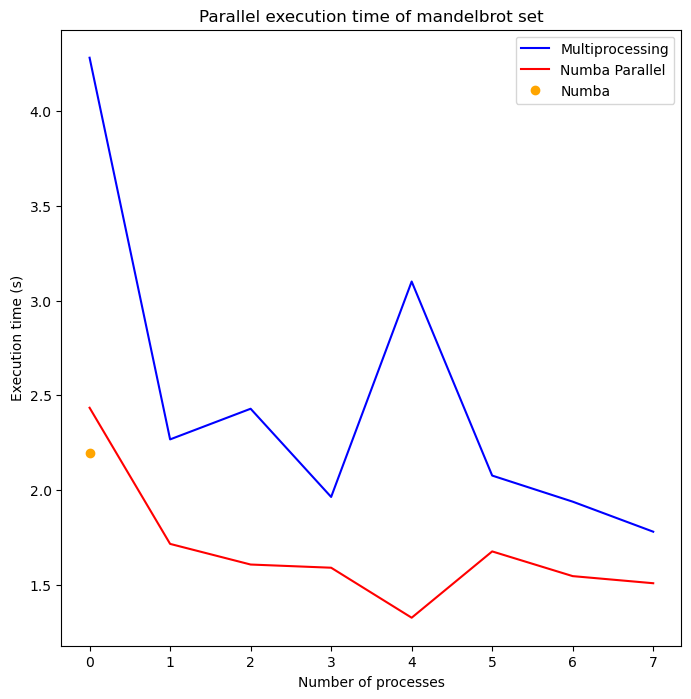

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
plt.plot(benchmarks_parallel["Multiprocessing"][0], label="Multiprocessing", c = "blue")
plt.plot(benchmarks_parallel["Numba Parallel"][0], label="Numba Parallel", c = "red")
plt.plot(benchmarks_parallel["Numba"][0], "o", label="Numba", c = "orange")
plt.legend()
plt.xlabel('Number of processes')
plt.ylabel('Execution time (s)')
plt.title('Parallel execution time of mandelbrot set')

The numba implementation is again the fastest. Although the stability is quite bad. There seems to be a core utilisation dropoff wth increasing number of cores. 

### Core utilisation
We can also estimate the core utilisation in crude manner by assuming that one core execution time is equivalent to one core utilised 100%. The core utilisation is then calculated as:

$$
\text{Core utilisation} = \frac{\text{Execution time for 1 core}}{\text{Execution time for N cores} \cdot \text{N}} \times 100\%
$$

As we could expect the execution time to drop by 2 using 2 cores, if they ulisize the cores 100%

/tmp/ipykernel_137972/1693282047.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


Text(0.5, 1.0, 'Utilisation of cores during parallel execution')

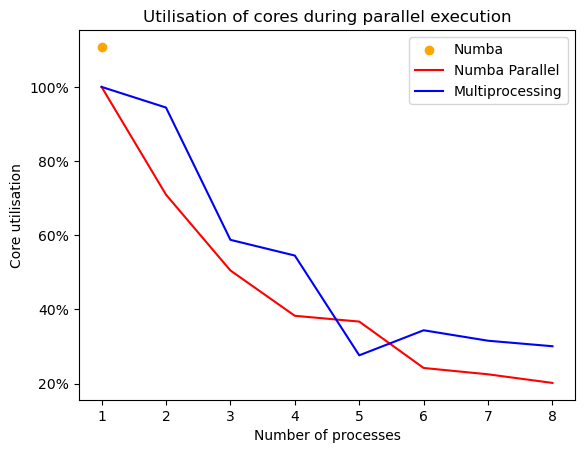

In [8]:
plt.scatter(
    benchmarks_parallel["Numba"][1], 
    benchmarks_parallel["Numba"][2], 
    label="Numba", c = "orange"
)

plt.plot(
    benchmarks_parallel["Numba Parallel"][1], 
    benchmarks_parallel["Numba Parallel"][2], 
    label="Numba Parallel", c = "red"
)
plt.plot(
    benchmarks_parallel["Multiprocessing"][1], 
    benchmarks_parallel["Multiprocessing"][2], 
    label="Multiprocessing", c = "blue"
)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.legend()
plt.xlabel('Number of processes')
plt.ylabel('Core utilisation')
plt.title('Utilisation of cores during parallel execution')

The utilisation drops off as more cores are used. 

## Software design

### modules
#### mandelbrot.py
The mandelbrot set estimation functions are grouped in two: 
1. Iterative approach
    * Inner function for estimating the divergence rate for a single complex number $c$
    * Outer function for iterating over a grid of complex numbers $c$ and calling the inner function for each $c$
    * Inclues naive, numba, numba parallel and multiprocessing implementations
2. Vectorised approach
    * Includes vectorised and numba vectorised implementations

#### benchmark.py
The benhmarking functionailty. It takes a function and a complex array as input and returns the execution time for the function. It also returns the result for evaluating the validity of the result.

#### visulaisation.py
Contains plotting functionality for plotting the divergence rate for each complex number $c$ in a grid.

#### utils.py
Only contains a function the generating a complex array of numbers $c$ in a grid.

#### GPT4.py
For fun, the implementation of mandelbrot.py function from promt: 

```
write me a function that calculates the divergence point if all values in an 2D numpy array of complex values. 

I want you to implement using different method, namely:

Basic python, e.g. for loop and native data structure such as lists. 

Numpy, utilising matrix operations 

Numba, e.g. using jit compiler on a numba compatible function to improve speed

Numba but with parallel processing

and finally using the multiprocessing module. 

Write all code with execution efficient as a top priority 
```

## Test plan

Test are primarily for ensuring correct output of mandelbrot set estimation functions, such they all agree on the divergence rate. 